In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
 

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Activation, Conv2DTranspose, ReLU, Flatten, Dense
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.models import load_model
import pandas as pd 
 
import os 
from PIL import Image

In [2]:
img_size = (128,128)

In [3]:
def build_generator():
    model = tf.keras.models.Sequential()
    
    # Initial dense layer
    model.add(layers.Dense(8 * 8 * 1024 , use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    input_channels = img_size[0]
    # Reshape into a feature map of size 8x8 with 256 channels
    model.add(layers.Reshape((8, 8, 1024)))
    
    #  8x8x1024 --> 16x16x512
    model.add(layers.Conv2DTranspose(input_channels * 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 16x16x512 --> 32x32x256
    model.add(layers.Conv2DTranspose(input_channels  * 2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 32x32x256 --> 64x64x128
    model.add(layers.Conv2DTranspose(input_channels, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
     # 64x64x128 --> 128x128x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsampling to 64x64
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    
    return model

 
# Initialize generator

generator = build_generator()

# Display summary
generator.summary()

c:\Users\vinew\anaconda3\envs\anime_gan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │     6,553,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 512)    │    13,107,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 64)   │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,232,384 (92.44 MB)

 Trainable params: 24,099,392 (91.93 MB)

 Non-trainable params: 132,992 (519.50 KB)

In [9]:
def generate_random_noise(batch_size, noise_dim):
   
                z = tf.random.uniform(minval=-1, maxval=1, shape=(batch_size,100))
                return tf.convert_to_tensor(z, dtype=tf.float32)
        

In [10]:
noise_dim = 100
num_samples = 16

In [11]:
def generate_and_visualize_samples(generator, noise_dim, num_samples):
    # Generate random noise
    
    
    # Generate images using the generator model
    generated_images = generator.predict(fixed_noise)
    
    # Check the shape of generated images
    print("Generated images shape:", generated_images.shape)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    
    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
discrimiator = load_model('discriminator_model.h5')

In [17]:
generator.load_weights('./checkpoints/generator_12_228.weights.h5')

In [13]:
discrimiator.load_weights('./checkpoints/discriminator_12_228.weights.h5')

In [14]:
logits_model = tf.keras.Model(inputs=discrimiator.input, outputs=discrimiator.get_layer('logits').output)

In [15]:
fixed_noise =  generate_random_noise(1, noise_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


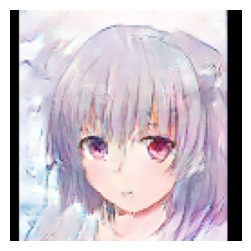

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.00038002]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probability of being a real image: [[0.500095]]


In [41]:
fixed_noise =  generate_random_noise(1, noise_dim)
generated_image = generator.predict(fixed_noise)
generated_images = 0.5 * generated_image + 0.5
    
    # Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(1):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')

plt.tight_layout()
plt.show()
print(discrimiator.predict(generated_image))
probability = tf.nn.sigmoid(discrimiator.predict(generated_image))
print("Probability of being a real image:", probability.numpy())

In [19]:
7.309986e-05 < 8.968431e-05

True

In [323]:
discrimiator.predict(generated_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[0.00105404]], dtype=float32)

In [324]:
probability = tf.nn.sigmoid(discrimiator.predict(generated_image))
print("Probability of being a real image:", probability.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Probability of being a real image: [[0.5002635]]


In [252]:
logits_model.predict(generated_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[-13.681147]], dtype=float32)

In [253]:
probability = tf.nn.sigmoid(logits_model.predict(generated_image))
print("Probability of being a real image:", probability.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Probability of being a real image: [[1.1438077e-06]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Generated images shape: (1, 128, 128, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

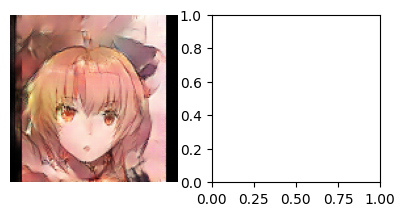

In [611]:
generator.load_weights("./checkpoints/generator_12_228.weights.h5")
generate_and_visualize_samples(generator, noise_dim, num_samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Generated images shape: (1, 128, 128, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

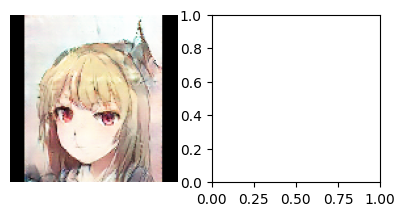

In [557]:
generator.load_weights("./checkpoints/generator_7_147.h5")
generate_and_visualize_samples(generator, noise_dim, num_samples)

In [41]:
training_log = pd.read_csv("training_15_log.csv")

<Axes: xlabel='epoch'>

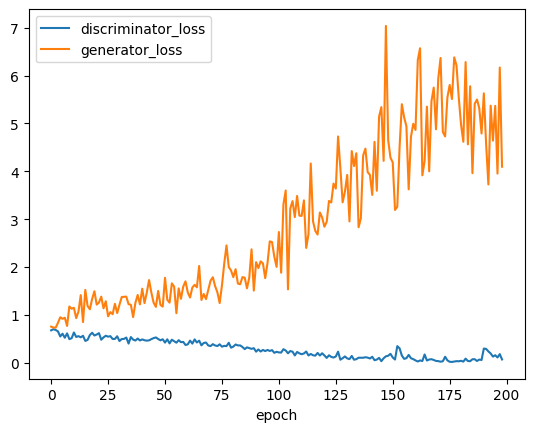

In [42]:
training_log.plot(x = 'epoch', y=['discriminator_loss','generator_loss'])